In [1]:
# freeze
from pathlib import Path

if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/gdrive')
    print('-------')
    %cd /gdrive/MyDrive/compVision-DCC/t1/
    print('-------')
elif Path.cwd().parent.stem == 't1':
    print('-------')
    %cd ..
    print('-------')
    

-------
/home/step/Personal/UCH/2021-sem1/VisionComp/t1
-------


In [2]:
import train
from train import *
from dataset import ClothingSmall, parse_function, train_preprocess
import matplotlib.pyplot as plt

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
print(train.__doc__)


jsaavedr, 2020
This allows you to train and test your model

Before using this program, set the path where the folder "covnet2"  is stored.
To use train.py, you will require to send the following parameters :
 * -config : A configuration file where a set of parameters for data construction and trainig is set.
 * -name: A section name in the configuration file.
 * -mode: [train, test] for training, testing, or showing  variables of the current model. By default this is set to 'train'
 * -save: Set true for saving the model


 Extension made by Victor Faraggi, 2021

 Added modularity. Now you can import the following functions:
    - create_config(name, config_file=None, config_str=None)
        -> return a ConfigurationFile from config_file path or config_str
    - parse_config(config)
        -> returns dict w/ tfr_files
    - load_dataset(config, tfr_train_file, tfr_test_file)
        -> returns a dict w/ train/test datasets, mean_image, input_shape and number_of_classes
    - create

# ResNext-50


In [9]:
resnext50_config = \
"""[FASHION-RESNEXT50]
# Training Related
NUM_EPOCHS = 20
NUM_CLASSES = 19
BATCH_SIZE = 128
SNAPSHOT_STEPS = 500
VALIDATION_STEPS = 100
LEARNING_RATE = 0.003
DECAY_STEPS = 40000
USE_L2 = True
WEIGHT_DECAY = 1e-2

SNAPSHOT_DIR = snapshots/snapshots-resnext/

# Dataset Related
DATA_DIR = data/clothing-small/
SHUFFLE_SIZE = 10000
CHANNELS = 3
IMAGE_TYPE = IMAGE
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

#for tf_records to use multithreads
USE_MULTITHREADS = True
NUM_THREADS = 10

#CKPFILE is used for fine tunning
#CKPFILE =/home/step/Personal/UCH/2021-sem1/VisionComp/t1/chks
"""

with open("configs/t1_resnext50.config", 'w') as conf:
    conf.write(resnext50_config)

## Configuration and Dataset

In [10]:
model_name = 'resnext'

config = create_config("FASHION-RESNEXT50", "configs/t1_resnext50.config")
tfr_files = parse_config(config, mode='train')
datasets = load_dataset(config, tfr_files['train'], tfr_files['test'], 'train')

In [11]:
process_func = lambda img, label : train_preprocess(img, label, seed=[8, 8])

csDataset = ClothingSmall(data_dir = config.get_data_dir())

csDataset.prepare()

csDataset.make_ds(parse_function, process_func)


# csDatasets = {
#     'train' : csDataset.train_ds,
#     'test' : csDataset.test_ds
# }

## Create Basic Callbacks

In [7]:
tb_cb, chk_cb = create_cbs(config)

### LRFinder

In [10]:
from custom import determine_learning_rate

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070, compute capability 8.6
Model is Resnext-50
(224, 224, 3)
Model: "res_next"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
backbone (ResNetBackbone)    multiple                  23033024  
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  38931     
Total params: 23,071,955
Trainable params: 23,011,283
Non-trainable params: 60,672
_________________________________________________________________
Epoch 1/5
500/500 [==============================] - 103s 185ms/step - loss: 7.5769 - accuracy: 

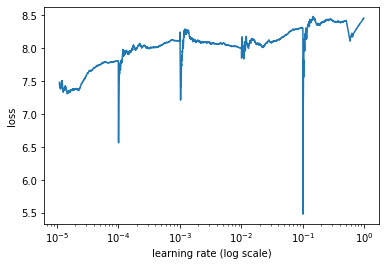

In [10]:
if lr_find:
    model = create_model(config, model_name, csDataset.input_shape, use_mixed=True)
    determine_learning_rate(model, datasets['train'], tf.keras.optimizers.SGD(), config.get_batch_size())

Model is Resnext-50
(224, 224, 3)
Model: "res_next_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
backbone (ResNetBackbone)    multiple                  23033024  
_________________________________________________________________
global_average_pooling2d_1 ( multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  38931     
Total params: 23,071,955
Trainable params: 23,011,283
Non-trainable params: 60,672
_________________________________________________________________
Epoch 1/5
500/500 [==============================] - 105s 194ms/step - loss: 7.7903 - accuracy: 0.0548
Epoch 2/5
500/500 [==============================] - 99s 188ms/step - loss: 8.2701 - accuracy: 0.0558
Epoch 3/5
500/500 [==============================] - 96s 182ms/step - loss: 8.2076 - accuracy: 0.0618
Epoch 4/5
500/500 [=========

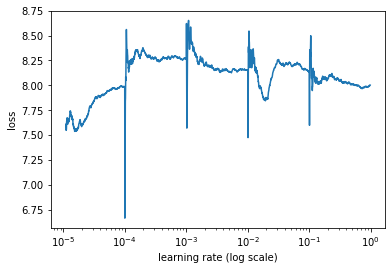

In [11]:
if lr_find:
    model = create_model(config, model_name, csDataset.input_shape, use_mixed=True)
    determine_learning_rate(model, datasets['train'], tf.keras.optimizers.Adam(), config.get_batch_size())

Model is Resnext-50
(224, 224, 3)
Model: "res_next_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
backbone (ResNetBackbone)    multiple                  23033024  
_________________________________________________________________
global_average_pooling2d_2 ( multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  38931     
Total params: 23,071,955
Trainable params: 23,011,283
Non-trainable params: 60,672
_________________________________________________________________
Epoch 1/5
500/500 [==============================] - 109s 196ms/step - loss: 7.9786 - accuracy: 0.0402
Epoch 2/5
500/500 [==============================] - 106s 202ms/step - loss: 8.3189 - accuracy: 0.0569
Epoch 3/5
500/500 [==============================] - 103s 195ms/step - loss: 8.4084 - accuracy: 0.0530
Epoch 4/5
500/500 [=======

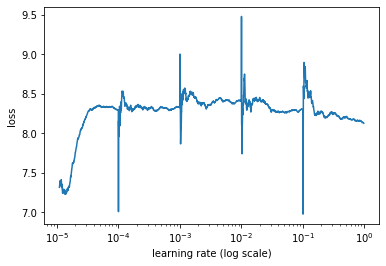

In [12]:
model = create_model(config, model_name, csDataset.input_shape, use_mixed=True)
determine_learning_rate(model, datasets['train'], tf.keras.optimizers.Nadam(), config.get_batch_size())

## Model

In [18]:
model = create_model(config, model_name, csDataset.input_shape, use_mixed=True)

Model is Resnext-50
(224, 224, 3)
Model: "res_next_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
backbone (ResNetBackbone)    multiple                  23033024  
_________________________________________________________________
global_average_pooling2d_1 ( multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  38931     
Total params: 23,071,955
Trainable params: 23,011,283
Non-trainable params: 60,672
_________________________________________________________________


## Run custom Dataset w/ custom scheduler

In [36]:
sched = create_scheduler(config, 'cyclic', {'base_lr': 1e-3, 'max_lr': 6e-3})
opt = create_opt('adam', config)

wtf


In [37]:
history = run_model('train', model, opt, csDatasets, config, [chk_cb], [tb_cb])

Epoch 1/20
  8/500 [..............................] - ETA: 1:13 - loss: 2.8946 - accuracy: 0.0465

KeyboardInterrupt: 

## Run custom Dataset w/ cosine scheduler

In [28]:
sched = create_scheduler(config, 'cosine')
opt = create_opt('adam', config, sched)

In [29]:
model = create_model(config, model_name, csDataset.input_shape, use_mixed=True)
history = run_model('train', model, opt, csDatasets, config, [chk_cb], [tb_cb])

Model is Resnext-50
(224, 224, 3)
Model: "res_next_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
backbone (ResNetBackbone)    multiple                  23033024  
_________________________________________________________________
global_average_pooling2d_2 ( multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  38931     
Total params: 23,071,955
Trainable params: 23,011,283
Non-trainable params: 60,672
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 82s 157ms/step - loss: 3.1994 - accuracy: 0.0628 - val_loss: nan - val_accuracy: 0.0511
Epoch 2/20
500/500 [==============================] - 78s 155ms/step - loss: 2.9120 - accuracy: 0.0639 - val_loss: 3.0104 - val_accuracy: 0.0663
Epoch 3/20
500/500 [============================

KeyboardInterrupt: 

## Run TFRecords Dataset w/ custom scheduler

In [38]:
sched = create_scheduler(config, 'cyclic', {'base_lr': 1e-3, 'max_lr': 8e-3})
opt = create_opt('adam', config)

In [39]:
datasets['train'] = datasets['train'].prefetch(1)
datasets['test'] = datasets['test'].prefetch(1)
model = create_model(config, model_name, csDataset.input_shape, use_mixed=True)
history = run_model('train', model, opt, datasets, config, [chk_cb, sched], [tb_cb])

Model is Resnext-50
(224, 224, 3)
Model: "res_next_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
backbone (ResNetBackbone)    multiple                  23033024  
_________________________________________________________________
global_average_pooling2d_3 ( multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  38931     
Total params: 23,071,955
Trainable params: 23,011,283
Non-trainable params: 60,672
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 89s 158ms/step - loss: 2.6342 - accuracy: 0.1880 - val_loss: 3.5703 - val_accuracy: 0.2132
Epoch 2/20
500/500 [==============================] - 82s 152ms/step - loss: 1.9784 - accuracy: 0.3600 - val_loss: 2.7396 - val_accuracy: 0.3153
Epoch 3/20
500/500 [=========================

### Best model at epochs 16 or 17 ---> upload

In [12]:
from sklearn.metrics import confusion_matrix

acc_dict = dict()
acc_per_class_dict = dict()

with tf.device('/gpu:0'):
    model = create_model(config, 'resnext', csDataset.input_shape, use_mixed=True)
    model.load_weights('snapshots/snapshots-resnext/016.h5')
    
    accs = []
    accs_per_class = []
    for x, y in datasets['test']:
        preds = model.predict(x)
        acc = (tf.math.argmax(preds, 1) == tf.math.argmax(y, 1)).numpy().sum() / len(y)
        
        matrix = confusion_matrix(tf.math.argmax(preds, 1), tf.math.argmax(y, 1))
        acc_per_class = matrix.diagonal()/(matrix.sum(axis=1) + 1e-8)
        
        accs.append(acc); accs_per_class.append(acc_per_class)
        
    accs = np.array(accs).mean()
    accs_per_class = np.array(accs_per_class).mean(1)
    
np.save('snapshots/snapshots-resnext/acc.npy', accs)
np.save('snapshots/snapshots-resnext/acc_classes.npy', accs_per_class)

Model is Resnext-50
(224, 224, 3)
Model: "res_next_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
backbone (ResNetBackbone)    multiple                  23033024  
_________________________________________________________________
global_average_pooling2d_1 ( multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  38931     
Total params: 23,071,955
Trainable params: 23,011,283
Non-trainable params: 60,672
_________________________________________________________________


In [13]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()